# Dimsum Calibration

1. Use adaptive binning on STREUSLE validation set with consolidated labels.
2. Use the bin boundaries from the STREUSLE validation set to calibrate dimsum_test.

In [1]:
# Notebook starts in notebooks folder. Change working directory back to streusle-tagger
%cd ../../../

C:\Michael\dev\streusle-tagger


In [2]:
import itertools
import math

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import sklearn.metrics

%matplotlib inline

In [3]:
def adaptive_binning(confidence_scores, labels, bin_size):
    """Assign (confidence_score, label) pairs to bins based on confidence_score."""
    
    num_bins = math.floor(len(confidence_scores) / bin_size)
    
    bins = []
    for i in range(num_bins):
        bins.append([])
    b = 0
    
    # Sort the data by score and put items in bins
    # Add integer index for recovering original order when measuring calibrated F1
    sorted_data = sorted(zip(confidence_scores, labels, list(range(len(confidence_scores)))), key=lambda x: x[0])
    for (score, label, index) in sorted_data:
        if len(bins[b]) < bin_size:
            bins[b].append((score, label, index))
        elif b == num_bins - 1:
            bins[b].append((score, label, index))
        else:
            b += 1
            bins[b].append((score, label, index))
    
    print("Items in last bin: ", len(bins[-1]))
    
    return bins

In [4]:
def estimate_calibration_error(bins):
    """Estimate calibration error from binned confidence scores and labels."""
    bin_square_errors = []
    average_scores = []
    average_labels = []
    square_errors = []
    for i, bin_i in enumerate(bins):
        average_score = sum([x for (x, y, z) in bin_i]) / len(bin_i)
        average_label = sum([y for (x, y, z) in bin_i]) / len(bin_i)
        average_scores.append(average_score)
        average_labels.append(average_label)
        square_error = (average_score - average_label) ** 2
        square_errors.append(square_error)
        bin_square_errors.append(len(bin_i) * square_error)
        
    calibration_error = math.sqrt(np.mean(bin_square_errors))
    return average_scores, average_labels, calibration_error

### Binning confidence scores from STREUSLE validation set

In [5]:
streusle_df = pd.read_csv("calibration/confidence_scores/validation/all_consolidated.csv")

labelset = streusle_df.columns[6:]
label_to_index = dict(zip(labelset, list(range(len(labelset)))))

streusle_confidence_scores = []
streusle_labels = []

for i, row in streusle_df.iterrows():
    confidence_scores = row[6:]
    label = row[4]
    label_index = label_to_index[label]
    binary_labels = np.zeros(len(labelset))
    binary_labels[label_index] = 1
    streusle_confidence_scores.append(list(confidence_scores))
    streusle_labels.append(list(binary_labels))
    
# These are both lists of lists. Flatten into single list.
streusle_confidence_scores = list(itertools.chain(*streusle_confidence_scores))
streusle_labels = list(itertools.chain(*streusle_labels))

In [6]:
bin_size = 200
streusle_bins = adaptive_binning(streusle_confidence_scores, streusle_labels, bin_size)

streusle_average_scores, streusle_average_labels, streusle_calibration_error = estimate_calibration_error(streusle_bins)
print("Streusle validation set calibration error: ", streusle_calibration_error)

Items in last bin:  252
Streusle validation set calibration error:  0.06466709380755645


### Putting DiMSUM scores in bins based on STREUSLE validation bin boundaries

In [7]:
dimsum_df = pd.read_csv("calibration/confidence_scores/dimsum_test/all_consolidated.csv")

dimsum_confidence_scores = []
dimsum_labels = []

for i, row in dimsum_df.iterrows():
    label_index = row[5]
    
    # If a row has a label_index of -1, that means it couldn't be mapped to the consolidated labelset and should be ingored.
    # These cases are rare (< 20)
    if label_index == -1:
        continue
        
    confidence_scores = row[6:]
    binary_labels = np.zeros(len(labelset))
    binary_labels[label_index] = 1
    dimsum_confidence_scores.append(list(confidence_scores))
    dimsum_labels.append(list(binary_labels))

# These are both lists of lists. Flatten into single list.
dimsum_confidence_scores = list(itertools.chain(*dimsum_confidence_scores))
dimsum_labels = list(itertools.chain(*dimsum_labels))

In [8]:
bin_info = []
for i, b in enumerate(streusle_bins):
    scores = list(zip(*b))[0]
    try:
        if i == 0:
            bin_info.append([-1, max(scores), streusle_average_labels[i]])
        else:
            bin_info.append([bin_info[i - 1][1], max(scores), streusle_average_labels[i]])
    except:
        print(bin_info[i-1])

In [9]:
def histogram_binning(confidence_scores, labels, bin_boundaries):
    """Bins confidence scores from second dataset according to boundaries determined in first dataset."""
    
    sorted_data = sorted(zip(confidence_scores, labels, list(range(len(confidence_scores)))), key=lambda x: x[0])
    
    num_bins = len(bin_boundaries)
    bins = []
    for i in range(num_bins):
        bins.append([])
    b = 0
    bin_boundaries[-1][1] = 999
    bin_boundaries[0][0] = -1
    start_bin = 0
    for j, (score, label, cell_id) in enumerate(sorted_data):
        for i, (low, high, _) in enumerate(bin_boundaries[start_bin:]):
            # Handle case where low equals high
            if low == high:
                if len(bins[i + start_bin] < bin_size):
                    bins[i + start_bin].append((score, label, cell_id))
                    start_bin = start_bin + i
            elif score >= low and score < high:
                bins[i + start_bin].append((score, label, cell_id))
                start_bin = start_bin + i
                break
    return bins

In [22]:
dimsum_bins = histogram_binning(dimsum_confidence_scores, dimsum_labels, bin_info)

In [23]:
# Ideally, these numbers will be fairly close to each other.
print(min([len(b) for b in dimsum_bins]))
print(max([len(b) for b in dimsum_bins]))

272
1845


In [25]:
dimsum_average_scores, dismum_average_labels, dimsum_uncalibrated_ce = estimate_calibration_error(dimsum_bins)
print(dimsum_uncalibrated_ce)

0.33037352095179573


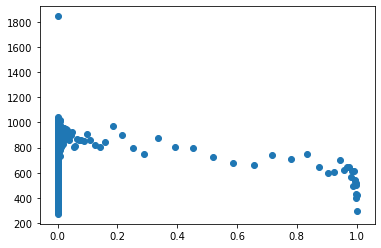

In [28]:
plt.scatter(dimsum_average_scores, [len(b) for b in dimsum_bins])

In [13]:
calibrated_confidence_scores = []

for i, b in enumerate(dimsum_bins):
    bin_scores = [bin_info[i][2]] * len(b)
    bin_labels = list(zip(*b))[1]
    score_ids = list(zip(*b))[2]
    calibrated_confidence_scores.append(list(zip(bin_scores, bin_labels, score_ids)))

### Results

In [14]:
dimsum_calibrated_average_scores, dimsum_calibrated_average_labels, dimsum_calibrated_ce = estimate_calibration_error(calibrated_confidence_scores)

In [15]:
print("DimSUM Calibration Error (uncalibrated): ", dimsum_uncalibrated_ce)
print("DimSUM Calibration Error (calibrated): ", dimsum_calibrated_ce)

DimSUM Calibration Error (uncalibrated):  0.33037352095179573
DimSUM Calibration Error (calibrated):  0.245468766854978


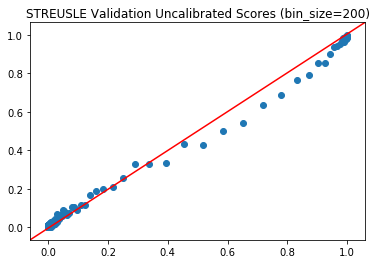

In [16]:
fig, ax = plt.subplots()
plt.scatter(streusle_average_scores, streusle_average_labels)
plt.title(f"STREUSLE Validation Uncalibrated Scores (bin_size={bin_size})")
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax.transAxes
ax.set_ylabel('Average Label of Bin')
ax.set_xlabel('Average Confidence Score of Bin')
line.set_transform(transform)
ax.add_line(line)

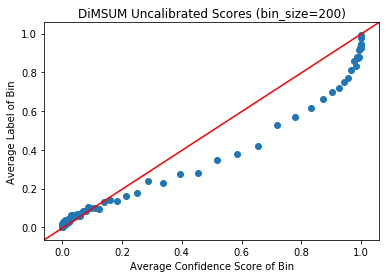

In [32]:
fig, ax = plt.subplots()
plt.scatter(dimsum_average_scores, dismum_average_labels)
plt.title(f"DiMSUM Uncalibrated Scores (bin_size={bin_size})")
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax.transAxes
ax.set_ylabel('Average Label of Bin')
ax.set_xlabel('Average Confidence Score of Bin')
line.set_transform(transform)
ax.add_line(line)

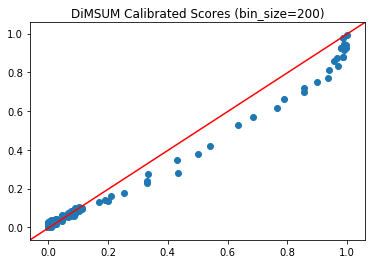

In [18]:
fig, ax = plt.subplots()
plt.scatter(dimsum_calibrated_average_scores, dimsum_calibrated_average_labels)
plt.title(f"DiMSUM Calibrated Scores (bin_size={bin_size})")
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax.transAxes
ax.set_ylabel('Average Label of Bin')
ax.set_xlabel('Average Confidence Score of Bin')
line.set_transform(transform)
ax.add_line(line)

These graphs for DiMSUM show that in general, the model tends to be overconfident in its predictions.

### DiMSUM with its own Bins

In [19]:
dimsum_bins = adaptive_binning(dimsum_confidence_scores, dimsum_labels, bin_size)

dimsum_average_scores, dimsum_average_labels, dimsum_calibration_error = estimate_calibration_error(dimsum_bins)

Items in last bin:  262


In [20]:
dimsum_calibration_error

0.19441692399060526

In [38]:
count = 0
for x in streusle_df["Ground"]:
    if x.startswith("B"):
        count += 1
print(count)

341


Above is how calibrated the model is on DiMSUM when it sets its own bin boundaries instead of using the boundaries of the STREUSLE bins. This figure is roughly 3 times the estimated calibration error on the STREUSLE validation set, relfecting the fact the the model is by default better calibrated for STREUSLE data than it is for DiMSUM data. Achieving this calibration error or lower with the STREUSLE bins is a best-case scenario.

## F1 Analysis

### DiMSUM (Test) F1

In [39]:
flattened_calibrated_confidence_scores = list(itertools.chain(*calibrated_confidence_scores))
scores_by_index = list(sorted(flattened_calibrated_confidence_scores, key=lambda x: x[2]))

In [40]:
len(labelset)

158

In [73]:
calibrated_scores = list(zip(*scores_by_index))[0]
calibrated_scores = np.array(calibrated_scores).reshape(-1, 158)

denominators = calibrated_scores.sum(axis=1)

# Calibrated scores don't sum to 1, so normalize
normalized_rows = []
for i in range(16489):
    normalized_row = [calibrated_scores[i][j] / denominators[i] for j in range(158)]
    normalized_rows.append(normalized_row)

# New prediction is max of calibrated score
calibrated_predictions = np.argmax(np.array(normalized_rows), axis=1)

dimsum_predictions = []
dimsum_indexes = []
# Ignore items with invalid ground truth label
for i, x in enumerate(dimsum_df["Predicted Index"]):
    if dimsum_df.iloc[i][5] != -1:
        dimsum_predictions.append(x)

dimsum_indexes = []
for x in dimsum_df["Ground Index"]:
    if x != -1:
        dimsum_indexes.append(x)

In [75]:
print(sklearn.metrics.f1_score(dimsum_indexes, dimsum_predictions, average="micro"))

calibrated_f1 = sklearn.metrics.f1_score(dimsum_indexes, calibrated_predictions, average="micro")
print("Post-calibration F1: ", calibrated_f1)

0.6891260840560374
Post-calibration F1:  0.6789981199587604


Note: This is **not true F1 on DiMSUM**. This is F1 on DiMSUM using the consolidated labelset produced for calibration.

### STREUSLE (Validation) F1

In [79]:
print(sklearn.metrics.f1_score(streusle_df["Ground Index"], streusle_df["Predicted Index"], average="micro"))

0.8479792361883575
